## Setting up
- Notebook for: `SGD(model.parameters(), lr=0.01)`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/"My Drive"/"Data Colab"/oml-project

/content/drive/My Drive/Data Colab/oml-project


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from tqdm import tqdm

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# hyperparameters
BATCH_SIZE = 64

In [ ]:
train_set = torchvision.datasets.CIFAR10('./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified


In [ ]:
test_set = torchvision.datasets.CIFAR10("./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()])) 

Files already downloaded and verified


In [ ]:
# sampling for smaller dataset: train
TRAIN_SAMPLES = int(len(train_set) / (10 * 2))
train_class_seen = dict([(i, 0) for i in range(10)])
train_indices = []
for i, (_, l) in enumerate(train_set):
  if train_class_seen[l] >= TRAIN_SAMPLES:
    continue
  train_class_seen[l] += 1
  train_indices.append(i)
train_subset = torch.utils.data.Subset(train_set, train_indices)
len(train_subset)

25000

In [ ]:
# sampling for smaller dataset: test
TEST_SAMPLES = int(len(test_set) / (10 * 3))
test_class_seen = dict([(i, 0) for i in range(10)])
test_indices = []
for i, (_, l) in enumerate(test_set):
  if test_class_seen[l] >= TEST_SAMPLES:
    continue
  test_class_seen[l] += 1
  test_indices.append(i)
test_subset = torch.utils.data.Subset(test_set, test_indices)
# store the test set as a single tensor
test_X, test_Y = [], []
for s, l in test_subset:
  test_X.append(s)
  test_Y.append(l)
test_X = torch.stack(test_X).float()
test_Y = torch.tensor(test_Y).long()
test_X, test_Y = test_X.to(device), test_Y.to(device)
test_X.shape, test_Y.shape

(torch.Size([3330, 3, 32, 32]), torch.Size([3330]))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## Analysis

In [ ]:
sample_image, sample_label = train_set[100]

In [ ]:
sample_image.shape

torch.Size([3, 32, 32])

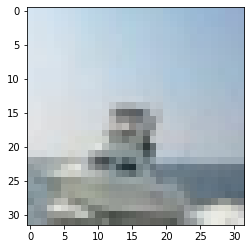

In [ ]:
plt.imshow(np.transpose(sample_image.numpy(), (1, 2, 0)))
plt.show()

In [ ]:
len(train_set), len(test_set)

(50000, 10000)

In [ ]:
sample_batch = next(iter(train_loader))
sample_batch = sample_batch[0].to(device), sample_batch[1].to(device)
sample_batch[0].shape, sample_batch[1].shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

## Model

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
    )
    self.lin = nn.Sequential(
        nn.Linear(in_features=32*15*15, out_features=600),
        nn.ReLU(),
        nn.Linear(in_features=600, out_features=120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features=10)
    )
    self.softmax = nn.LogSoftmax(dim=1)
  def forward(self, x):
    out = self.conv(x)
    out = out.view(out.size(0), -1)
    out = self.lin(out)
    out = self.softmax(out)
    return out
model = CNN()
model.to(device)

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (lin): Sequential(
    (0): Linear(in_features=7200, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=120, bias=True)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=10, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
# hyperparameters
NUM_EPOCHS = 100

In [ ]:
error = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Training

In [ ]:
DISPLAY_INTERVAL = 1
train_loss, test_loss = [], [] # denotes the mean loss over all samples
train_acc, test_acc = [], []
for epoch in range(1, NUM_EPOCHS + 1):
  total_loss = 0
  correct, total = 0, 0
  for images, labels in tqdm(train_loader):
    # forward + backward + step
    optimizer.zero_grad()
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = error(outputs, labels)
    total_loss += loss.item() * len(outputs)
    loss.backward()
    optimizer.step()
    # accuracy calculation
    correct += (torch.argmax(outputs, dim=1) == labels).sum()
    total += len(labels)
  train_loss.append(total_loss / total)
  train_acc.append(correct / total)
  # testing loss
  with torch.no_grad():
    predicted = model(test_X)
    loss = error(predicted, test_Y)
    test_loss.append(loss.item())
    test_acc.append((torch.argmax(predicted, dim=1) == test_Y).sum() / len(test_Y))

  if epoch % DISPLAY_INTERVAL == 0:
      print(f'Performace at epoch {epoch}')
      print(f'Train Loss: {train_loss[-1]:.5f} ; Train Acc: {train_acc[-1]:.5f}')
      print(f'Test Loss: {test_loss[-1]:.5f} ; Test Acc: {test_acc[-1]:.5f}')
      print('==============')

100%|██████████| 391/391 [00:05<00:00, 67.89it/s]


Performace at epoch 1
Train Loss: 2.25903 ; Train Acc: 0.19500
Test Loss: 2.17610 ; Test Acc: 0.24354


100%|██████████| 391/391 [00:05<00:00, 69.59it/s]


Performace at epoch 2
Train Loss: 2.06377 ; Train Acc: 0.25972
Test Loss: 2.00137 ; Test Acc: 0.25976


100%|██████████| 391/391 [00:05<00:00, 70.45it/s]


Performace at epoch 3
Train Loss: 1.95578 ; Train Acc: 0.29480
Test Loss: 1.91130 ; Test Acc: 0.33003


100%|██████████| 391/391 [00:05<00:00, 71.62it/s]


Performace at epoch 4
Train Loss: 1.89353 ; Train Acc: 0.32368
Test Loss: 1.88227 ; Test Acc: 0.33544


100%|██████████| 391/391 [00:05<00:00, 70.80it/s]


Performace at epoch 5
Train Loss: 1.83693 ; Train Acc: 0.34592
Test Loss: 1.83453 ; Test Acc: 0.34444


100%|██████████| 391/391 [00:05<00:00, 70.28it/s]


Performace at epoch 6
Train Loss: 1.77001 ; Train Acc: 0.36940
Test Loss: 1.71698 ; Test Acc: 0.39940


100%|██████████| 391/391 [00:05<00:00, 70.64it/s]


Performace at epoch 7
Train Loss: 1.70203 ; Train Acc: 0.39028
Test Loss: 1.66774 ; Test Acc: 0.41832


100%|██████████| 391/391 [00:05<00:00, 69.93it/s]


Performace at epoch 8
Train Loss: 1.63421 ; Train Acc: 0.41224
Test Loss: 1.60758 ; Test Acc: 0.42252


100%|██████████| 391/391 [00:05<00:00, 70.05it/s]


Performace at epoch 9
Train Loss: 1.57297 ; Train Acc: 0.43332
Test Loss: 1.55671 ; Test Acc: 0.43964


100%|██████████| 391/391 [00:05<00:00, 70.44it/s]


Performace at epoch 10
Train Loss: 1.52162 ; Train Acc: 0.45052
Test Loss: 1.48228 ; Test Acc: 0.46486


100%|██████████| 391/391 [00:05<00:00, 70.46it/s]


Performace at epoch 11
Train Loss: 1.46913 ; Train Acc: 0.47008
Test Loss: 1.46737 ; Test Acc: 0.46486


100%|██████████| 391/391 [00:05<00:00, 70.63it/s]


Performace at epoch 12
Train Loss: 1.42696 ; Train Acc: 0.48600
Test Loss: 1.41560 ; Test Acc: 0.49039


100%|██████████| 391/391 [00:05<00:00, 69.18it/s]


Performace at epoch 13
Train Loss: 1.38602 ; Train Acc: 0.49948
Test Loss: 1.39198 ; Test Acc: 0.49760


100%|██████████| 391/391 [00:05<00:00, 69.74it/s]


Performace at epoch 14
Train Loss: 1.34438 ; Train Acc: 0.51744
Test Loss: 1.44428 ; Test Acc: 0.48979


100%|██████████| 391/391 [00:05<00:00, 70.31it/s]


Performace at epoch 15
Train Loss: 1.30781 ; Train Acc: 0.52996
Test Loss: 1.31222 ; Test Acc: 0.52703


100%|██████████| 391/391 [00:05<00:00, 70.26it/s]


Performace at epoch 16
Train Loss: 1.27689 ; Train Acc: 0.54276
Test Loss: 1.33650 ; Test Acc: 0.52222


100%|██████████| 391/391 [00:05<00:00, 69.59it/s]


Performace at epoch 17
Train Loss: 1.24427 ; Train Acc: 0.55592
Test Loss: 1.27376 ; Test Acc: 0.53844


100%|██████████| 391/391 [00:05<00:00, 70.20it/s]


Performace at epoch 18
Train Loss: 1.21224 ; Train Acc: 0.56756
Test Loss: 1.25072 ; Test Acc: 0.55225


100%|██████████| 391/391 [00:05<00:00, 69.35it/s]


Performace at epoch 19
Train Loss: 1.18367 ; Train Acc: 0.57728
Test Loss: 1.22336 ; Test Acc: 0.55886


100%|██████████| 391/391 [00:05<00:00, 69.77it/s]


Performace at epoch 20
Train Loss: 1.15562 ; Train Acc: 0.58968
Test Loss: 1.22576 ; Test Acc: 0.56607


100%|██████████| 391/391 [00:05<00:00, 70.51it/s]


Performace at epoch 21
Train Loss: 1.12890 ; Train Acc: 0.59804
Test Loss: 1.27183 ; Test Acc: 0.54775


100%|██████████| 391/391 [00:05<00:00, 70.47it/s]


Performace at epoch 22
Train Loss: 1.10464 ; Train Acc: 0.61048
Test Loss: 1.24593 ; Test Acc: 0.55736


100%|██████████| 391/391 [00:05<00:00, 69.61it/s]


Performace at epoch 23
Train Loss: 1.08050 ; Train Acc: 0.61776
Test Loss: 1.19773 ; Test Acc: 0.57027


100%|██████████| 391/391 [00:05<00:00, 69.00it/s]


Performace at epoch 24
Train Loss: 1.05649 ; Train Acc: 0.62444
Test Loss: 1.19965 ; Test Acc: 0.57357


100%|██████████| 391/391 [00:05<00:00, 69.10it/s]


Performace at epoch 25
Train Loss: 1.02826 ; Train Acc: 0.63828
Test Loss: 1.17806 ; Test Acc: 0.57598


100%|██████████| 391/391 [00:05<00:00, 70.30it/s]


Performace at epoch 26
Train Loss: 1.00054 ; Train Acc: 0.64824
Test Loss: 1.19973 ; Test Acc: 0.57628


100%|██████████| 391/391 [00:05<00:00, 69.75it/s]


Performace at epoch 27
Train Loss: 0.97871 ; Train Acc: 0.65488
Test Loss: 1.13965 ; Test Acc: 0.59189


100%|██████████| 391/391 [00:05<00:00, 69.17it/s]


Performace at epoch 28
Train Loss: 0.95224 ; Train Acc: 0.66644
Test Loss: 1.13155 ; Test Acc: 0.58769


100%|██████████| 391/391 [00:05<00:00, 68.62it/s]


Performace at epoch 29
Train Loss: 0.92557 ; Train Acc: 0.67512
Test Loss: 1.17165 ; Test Acc: 0.58559


100%|██████████| 391/391 [00:05<00:00, 68.84it/s]


Performace at epoch 30
Train Loss: 0.90199 ; Train Acc: 0.68320
Test Loss: 1.12924 ; Test Acc: 0.60150


100%|██████████| 391/391 [00:05<00:00, 68.83it/s]


Performace at epoch 31
Train Loss: 0.87375 ; Train Acc: 0.69668
Test Loss: 1.13557 ; Test Acc: 0.58979


100%|██████████| 391/391 [00:05<00:00, 69.93it/s]


Performace at epoch 32
Train Loss: 0.84451 ; Train Acc: 0.70660
Test Loss: 1.17679 ; Test Acc: 0.58559


100%|██████████| 391/391 [00:05<00:00, 68.22it/s]


Performace at epoch 33
Train Loss: 0.81673 ; Train Acc: 0.71604
Test Loss: 1.17812 ; Test Acc: 0.58679


100%|██████████| 391/391 [00:05<00:00, 68.90it/s]


Performace at epoch 34
Train Loss: 0.78659 ; Train Acc: 0.72584
Test Loss: 1.16753 ; Test Acc: 0.58919


100%|██████████| 391/391 [00:05<00:00, 69.90it/s]


Performace at epoch 35
Train Loss: 0.75199 ; Train Acc: 0.73808
Test Loss: 1.14381 ; Test Acc: 0.60150


100%|██████████| 391/391 [00:05<00:00, 69.17it/s]


Performace at epoch 36
Train Loss: 0.72781 ; Train Acc: 0.74880
Test Loss: 1.15378 ; Test Acc: 0.59790


100%|██████████| 391/391 [00:05<00:00, 69.98it/s]


Performace at epoch 37
Train Loss: 0.69167 ; Train Acc: 0.76392
Test Loss: 1.16629 ; Test Acc: 0.60300


100%|██████████| 391/391 [00:05<00:00, 69.17it/s]


Performace at epoch 38
Train Loss: 0.66428 ; Train Acc: 0.77556
Test Loss: 1.15635 ; Test Acc: 0.61171


100%|██████████| 391/391 [00:05<00:00, 68.91it/s]


Performace at epoch 39
Train Loss: 0.62393 ; Train Acc: 0.79096
Test Loss: 1.12769 ; Test Acc: 0.62102


100%|██████████| 391/391 [00:05<00:00, 69.22it/s]


Performace at epoch 40
Train Loss: 0.59724 ; Train Acc: 0.79872
Test Loss: 1.19295 ; Test Acc: 0.60030


100%|██████████| 391/391 [00:05<00:00, 69.20it/s]


Performace at epoch 41
Train Loss: 0.55922 ; Train Acc: 0.81388
Test Loss: 1.17849 ; Test Acc: 0.60631


100%|██████████| 391/391 [00:05<00:00, 68.85it/s]


Performace at epoch 42
Train Loss: 0.53083 ; Train Acc: 0.82540
Test Loss: 1.18093 ; Test Acc: 0.61291


100%|██████████| 391/391 [00:05<00:00, 68.81it/s]


Performace at epoch 43
Train Loss: 0.49466 ; Train Acc: 0.83932
Test Loss: 1.19070 ; Test Acc: 0.61021


100%|██████████| 391/391 [00:05<00:00, 68.50it/s]


Performace at epoch 44
Train Loss: 0.46362 ; Train Acc: 0.84952
Test Loss: 1.28352 ; Test Acc: 0.59910


100%|██████████| 391/391 [00:05<00:00, 69.02it/s]


Performace at epoch 45
Train Loss: 0.42307 ; Train Acc: 0.86796
Test Loss: 1.18921 ; Test Acc: 0.61411


100%|██████████| 391/391 [00:05<00:00, 69.03it/s]


Performace at epoch 46
Train Loss: 0.39556 ; Train Acc: 0.87704
Test Loss: 1.27914 ; Test Acc: 0.60360


100%|██████████| 391/391 [00:05<00:00, 68.23it/s]


Performace at epoch 47
Train Loss: 0.35771 ; Train Acc: 0.89068
Test Loss: 1.36115 ; Test Acc: 0.59339


100%|██████████| 391/391 [00:05<00:00, 69.47it/s]


Performace at epoch 48
Train Loss: 0.32868 ; Train Acc: 0.90344
Test Loss: 1.22666 ; Test Acc: 0.61922


100%|██████████| 391/391 [00:05<00:00, 68.45it/s]


Performace at epoch 49
Train Loss: 0.29101 ; Train Acc: 0.91884
Test Loss: 1.28591 ; Test Acc: 0.61532


100%|██████████| 391/391 [00:05<00:00, 69.46it/s]


Performace at epoch 50
Train Loss: 0.26574 ; Train Acc: 0.92780
Test Loss: 1.33655 ; Test Acc: 0.61411


100%|██████████| 391/391 [00:05<00:00, 68.96it/s]


Performace at epoch 51
Train Loss: 0.24237 ; Train Acc: 0.93540
Test Loss: 1.30238 ; Test Acc: 0.61982


100%|██████████| 391/391 [00:05<00:00, 68.90it/s]


Performace at epoch 52
Train Loss: 0.21749 ; Train Acc: 0.94428
Test Loss: 1.41208 ; Test Acc: 0.60330


100%|██████████| 391/391 [00:05<00:00, 68.99it/s]


Performace at epoch 53
Train Loss: 0.18734 ; Train Acc: 0.95564
Test Loss: 1.33745 ; Test Acc: 0.62372


100%|██████████| 391/391 [00:05<00:00, 68.76it/s]


Performace at epoch 54
Train Loss: 0.16505 ; Train Acc: 0.96252
Test Loss: 1.42788 ; Test Acc: 0.61081


100%|██████████| 391/391 [00:05<00:00, 69.04it/s]


Performace at epoch 55
Train Loss: 0.14667 ; Train Acc: 0.96880
Test Loss: 1.48563 ; Test Acc: 0.61532


100%|██████████| 391/391 [00:05<00:00, 68.94it/s]


Performace at epoch 56
Train Loss: 0.12375 ; Train Acc: 0.97804
Test Loss: 1.44309 ; Test Acc: 0.61862


100%|██████████| 391/391 [00:05<00:00, 69.39it/s]


Performace at epoch 57
Train Loss: 0.10564 ; Train Acc: 0.98236
Test Loss: 1.51609 ; Test Acc: 0.61201


100%|██████████| 391/391 [00:05<00:00, 69.56it/s]


Performace at epoch 58
Train Loss: 0.09829 ; Train Acc: 0.98420
Test Loss: 1.51917 ; Test Acc: 0.62763


100%|██████████| 391/391 [00:05<00:00, 69.47it/s]


Performace at epoch 59
Train Loss: 0.07884 ; Train Acc: 0.99004
Test Loss: 1.54686 ; Test Acc: 0.61652


100%|██████████| 391/391 [00:05<00:00, 67.72it/s]


Performace at epoch 60
Train Loss: 0.06768 ; Train Acc: 0.99304
Test Loss: 1.56946 ; Test Acc: 0.62402


100%|██████████| 391/391 [00:05<00:00, 68.30it/s]


Performace at epoch 61
Train Loss: 0.06408 ; Train Acc: 0.99296
Test Loss: 1.54349 ; Test Acc: 0.63153


100%|██████████| 391/391 [00:05<00:00, 68.68it/s]


Performace at epoch 62
Train Loss: 0.05166 ; Train Acc: 0.99596
Test Loss: 1.58356 ; Test Acc: 0.62943


100%|██████████| 391/391 [00:05<00:00, 68.36it/s]


Performace at epoch 63
Train Loss: 0.04481 ; Train Acc: 0.99700
Test Loss: 1.63744 ; Test Acc: 0.62162


100%|██████████| 391/391 [00:05<00:00, 68.65it/s]


Performace at epoch 64
Train Loss: 0.03827 ; Train Acc: 0.99792
Test Loss: 1.67238 ; Test Acc: 0.62883


100%|██████████| 391/391 [00:05<00:00, 68.44it/s]


Performace at epoch 65
Train Loss: 0.03374 ; Train Acc: 0.99828
Test Loss: 1.65051 ; Test Acc: 0.62853


100%|██████████| 391/391 [00:05<00:00, 68.34it/s]


Performace at epoch 66
Train Loss: 0.03225 ; Train Acc: 0.99836
Test Loss: 1.68840 ; Test Acc: 0.62523


100%|██████████| 391/391 [00:05<00:00, 69.13it/s]


Performace at epoch 67
Train Loss: 0.02765 ; Train Acc: 0.99884
Test Loss: 1.70166 ; Test Acc: 0.62613


100%|██████████| 391/391 [00:05<00:00, 68.84it/s]


Performace at epoch 68
Train Loss: 0.02479 ; Train Acc: 0.99916
Test Loss: 1.71696 ; Test Acc: 0.62523


100%|██████████| 391/391 [00:05<00:00, 68.95it/s]


Performace at epoch 69
Train Loss: 0.02237 ; Train Acc: 0.99928
Test Loss: 1.75497 ; Test Acc: 0.63093


100%|██████████| 391/391 [00:05<00:00, 68.81it/s]


Performace at epoch 70
Train Loss: 0.02008 ; Train Acc: 0.99940
Test Loss: 1.75748 ; Test Acc: 0.63333


100%|██████████| 391/391 [00:05<00:00, 67.95it/s]


Performace at epoch 71
Train Loss: 0.01873 ; Train Acc: 0.99936
Test Loss: 1.77149 ; Test Acc: 0.63303


100%|██████████| 391/391 [00:05<00:00, 68.34it/s]


Performace at epoch 72
Train Loss: 0.01760 ; Train Acc: 0.99940
Test Loss: 1.79496 ; Test Acc: 0.63153


100%|██████████| 391/391 [00:05<00:00, 68.76it/s]


Performace at epoch 73
Train Loss: 0.01559 ; Train Acc: 0.99976
Test Loss: 1.82400 ; Test Acc: 0.62553


100%|██████████| 391/391 [00:05<00:00, 68.75it/s]


Performace at epoch 74
Train Loss: 0.01507 ; Train Acc: 0.99952
Test Loss: 1.82766 ; Test Acc: 0.62703


100%|██████████| 391/391 [00:05<00:00, 68.04it/s]


Performace at epoch 75
Train Loss: 0.01377 ; Train Acc: 0.99976
Test Loss: 1.83409 ; Test Acc: 0.63333


100%|██████████| 391/391 [00:05<00:00, 67.62it/s]


Performace at epoch 76
Train Loss: 0.01309 ; Train Acc: 0.99960
Test Loss: 1.85773 ; Test Acc: 0.63483


100%|██████████| 391/391 [00:05<00:00, 68.81it/s]


Performace at epoch 77
Train Loss: 0.01191 ; Train Acc: 0.99980
Test Loss: 1.86423 ; Test Acc: 0.62853


100%|██████████| 391/391 [00:05<00:00, 68.71it/s]


Performace at epoch 78
Train Loss: 0.01113 ; Train Acc: 0.99992
Test Loss: 1.88694 ; Test Acc: 0.62913


100%|██████████| 391/391 [00:05<00:00, 68.55it/s]


Performace at epoch 79
Train Loss: 0.01074 ; Train Acc: 0.99976
Test Loss: 1.89717 ; Test Acc: 0.62763


100%|██████████| 391/391 [00:05<00:00, 68.20it/s]


Performace at epoch 80
Train Loss: 0.01091 ; Train Acc: 0.99960
Test Loss: 1.89578 ; Test Acc: 0.63093


100%|██████████| 391/391 [00:05<00:00, 69.15it/s]


Performace at epoch 81
Train Loss: 0.00973 ; Train Acc: 0.99976
Test Loss: 1.92508 ; Test Acc: 0.62763


100%|██████████| 391/391 [00:05<00:00, 67.89it/s]


Performace at epoch 82
Train Loss: 0.00932 ; Train Acc: 0.99992
Test Loss: 1.91728 ; Test Acc: 0.63363


100%|██████████| 391/391 [00:05<00:00, 68.12it/s]


Performace at epoch 83
Train Loss: 0.00851 ; Train Acc: 0.99988
Test Loss: 1.93485 ; Test Acc: 0.63483


100%|██████████| 391/391 [00:05<00:00, 68.07it/s]


Performace at epoch 84
Train Loss: 0.00804 ; Train Acc: 0.99992
Test Loss: 1.94839 ; Test Acc: 0.62883


100%|██████████| 391/391 [00:05<00:00, 68.47it/s]


Performace at epoch 85
Train Loss: 0.00766 ; Train Acc: 0.99996
Test Loss: 1.96743 ; Test Acc: 0.62913


100%|██████████| 391/391 [00:05<00:00, 68.37it/s]


Performace at epoch 86
Train Loss: 0.00762 ; Train Acc: 0.99980
Test Loss: 1.96636 ; Test Acc: 0.63033


100%|██████████| 391/391 [00:05<00:00, 68.70it/s]


Performace at epoch 87
Train Loss: 0.00698 ; Train Acc: 1.00000
Test Loss: 1.99122 ; Test Acc: 0.63153


100%|██████████| 391/391 [00:05<00:00, 67.86it/s]


Performace at epoch 88
Train Loss: 0.00678 ; Train Acc: 0.99988
Test Loss: 1.98815 ; Test Acc: 0.62913


100%|██████████| 391/391 [00:05<00:00, 66.90it/s]


Performace at epoch 89
Train Loss: 0.00655 ; Train Acc: 0.99992
Test Loss: 1.99914 ; Test Acc: 0.62643


100%|██████████| 391/391 [00:05<00:00, 68.47it/s]


Performace at epoch 90
Train Loss: 0.00641 ; Train Acc: 0.99984
Test Loss: 2.00744 ; Test Acc: 0.63093


100%|██████████| 391/391 [00:05<00:00, 67.36it/s]


Performace at epoch 91
Train Loss: 0.00582 ; Train Acc: 1.00000
Test Loss: 2.01582 ; Test Acc: 0.63033


100%|██████████| 391/391 [00:05<00:00, 68.09it/s]


Performace at epoch 92
Train Loss: 0.00621 ; Train Acc: 0.99968
Test Loss: 2.03943 ; Test Acc: 0.63153


100%|██████████| 391/391 [00:05<00:00, 67.22it/s]


Performace at epoch 93
Train Loss: 0.00547 ; Train Acc: 1.00000
Test Loss: 2.02423 ; Test Acc: 0.62883


100%|██████████| 391/391 [00:05<00:00, 67.48it/s]


Performace at epoch 94
Train Loss: 0.00561 ; Train Acc: 0.99988
Test Loss: 2.04622 ; Test Acc: 0.62823


100%|██████████| 391/391 [00:05<00:00, 68.60it/s]


Performace at epoch 95
Train Loss: 0.00513 ; Train Acc: 1.00000
Test Loss: 2.04962 ; Test Acc: 0.62733


100%|██████████| 391/391 [00:05<00:00, 67.49it/s]


Performace at epoch 96
Train Loss: 0.00494 ; Train Acc: 1.00000
Test Loss: 2.05439 ; Test Acc: 0.63153


100%|██████████| 391/391 [00:05<00:00, 68.88it/s]


Performace at epoch 97
Train Loss: 0.00497 ; Train Acc: 0.99992
Test Loss: 2.06203 ; Test Acc: 0.63003


100%|██████████| 391/391 [00:05<00:00, 68.38it/s]


Performace at epoch 98
Train Loss: 0.00460 ; Train Acc: 1.00000
Test Loss: 2.07490 ; Test Acc: 0.63003


100%|██████████| 391/391 [00:05<00:00, 68.96it/s]


Performace at epoch 99
Train Loss: 0.00446 ; Train Acc: 1.00000
Test Loss: 2.08008 ; Test Acc: 0.62973


100%|██████████| 391/391 [00:05<00:00, 67.50it/s]

Performace at epoch 100
Train Loss: 0.00429 ; Train Acc: 1.00000
Test Loss: 2.08646 ; Test Acc: 0.63183


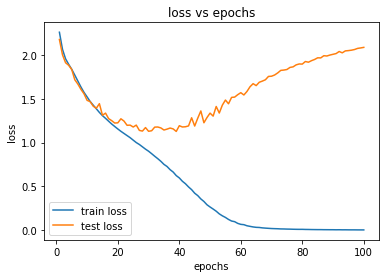

In [ ]:
# plot loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='train loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
plt.legend()
plt.show()

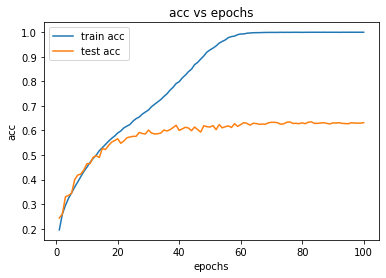

In [ ]:
# plot acc
plt.plot(range(1, NUM_EPOCHS + 1), train_acc, label='train acc')
plt.plot(range(1, NUM_EPOCHS + 1), test_acc, label='test acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title('acc vs epochs')
plt.legend()
plt.show()

## Hyperparameter tuning
- For a set of hyperparameters, various trials with different models are trained based on randomly-sampled or exhaustive hyperparameters upto a certain number of epochs (dependent on lr). Finally the best set of hyperparameters are chosen which correspond to the minimum testing loss after training.

In [ ]:
import decimal

In [ ]:
HYPERPARAMS = {
    'lr': [0.1, 0.05, 0.01, 0.005, 0.001, 0.0001]
}
TRIALS = 6

def get_epochs(lr):
    '''
    returns number of epochs for a given learning rate while tuning
    '''
    d = decimal.Decimal(str(lr))
    pow = d.as_tuple().exponent
    if pow >= -1:
        return 10
    elif pow >= -2:
        return 15
    elif pow >= -3:
        return 20
    else:
        return 25

In [ ]:
best_params, min_loss = None, np.inf
for t in range(TRIALS):
    print(f'\n> Starting trial {t+1}')
    ## choose a set of hyperparameters
    chosen = {}
    for h in HYPERPARAMS:
        chosen[h] = HYPERPARAMS[h][t]
    print(f'Chosen hyperparams: {chosen}')
    print()
    ## model, loss & optimizer
    model = CNN()
    model.to(device)
    error = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=chosen['lr'])
    ## training
    EPOCHS_TEST = get_epochs(chosen['lr'])
    for epoch in range(1, EPOCHS_TEST + 1):
        total_loss = 0; total = 0
        for images, labels in tqdm(train_loader):
            # forward + backward + step
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = error(outputs, labels)
            total_loss += loss.item() * len(outputs)
            loss.backward() 
            optimizer.step() 
            total += len(labels)
        total_loss /= total
        print(f'Training loss at epoch {epoch}: {total_loss:.5f}')
    ## calculate testing loss
    with torch.no_grad():
        predicted = model(test_X)
        testing_loss = error(predicted, test_Y).item()
    print(f'* Testing loss: {testing_loss:.5f}')
    ## check final total loss
    if testing_loss < min_loss:
        min_loss = testing_loss
        best_params = chosen
        print()
        print(f'* Best params updated!: {best_params}')
    print('==============')


> Starting trial 1
Chosen hyperparams: {'lr': 0.1}



100%|██████████| 391/391 [00:05<00:00, 67.61it/s]


Training loss at epoch 1: 2.02724


100%|██████████| 391/391 [00:05<00:00, 68.14it/s]


Training loss at epoch 2: 1.66632


100%|██████████| 391/391 [00:05<00:00, 68.66it/s]


Training loss at epoch 3: 1.42582


100%|██████████| 391/391 [00:05<00:00, 68.06it/s]


Training loss at epoch 4: 1.26871


100%|██████████| 391/391 [00:05<00:00, 68.68it/s]


Training loss at epoch 5: 1.12120


100%|██████████| 391/391 [00:05<00:00, 68.54it/s]


Training loss at epoch 6: 0.98818


100%|██████████| 391/391 [00:05<00:00, 68.50it/s]


Training loss at epoch 7: 0.86218


100%|██████████| 391/391 [00:05<00:00, 67.81it/s]


Training loss at epoch 8: 0.71139


100%|██████████| 391/391 [00:05<00:00, 67.01it/s]


Training loss at epoch 9: 0.56627


100%|██████████| 391/391 [00:05<00:00, 68.85it/s]


Training loss at epoch 10: 0.41208
* Testing loss: 1.42926

* Best params updated!: {'lr': 0.1}

> Starting trial 2
Chosen hyperparams: {'lr': 0.05}



100%|██████████| 391/391 [00:05<00:00, 69.30it/s]


Training loss at epoch 1: 2.09937


100%|██████████| 391/391 [00:05<00:00, 69.16it/s]


Training loss at epoch 2: 1.78065


100%|██████████| 391/391 [00:05<00:00, 68.47it/s]


Training loss at epoch 3: 1.56617


100%|██████████| 391/391 [00:05<00:00, 67.61it/s]


Training loss at epoch 4: 1.43476


100%|██████████| 391/391 [00:05<00:00, 67.32it/s]


Training loss at epoch 5: 1.31816


100%|██████████| 391/391 [00:05<00:00, 68.31it/s]


Training loss at epoch 6: 1.20661


100%|██████████| 391/391 [00:05<00:00, 68.43it/s]


Training loss at epoch 7: 1.12258


100%|██████████| 391/391 [00:05<00:00, 68.09it/s]


Training loss at epoch 8: 1.02244


100%|██████████| 391/391 [00:05<00:00, 68.62it/s]


Training loss at epoch 9: 0.92834


100%|██████████| 391/391 [00:05<00:00, 69.12it/s]


Training loss at epoch 10: 0.83490


100%|██████████| 391/391 [00:05<00:00, 68.22it/s]


Training loss at epoch 11: 0.72419


100%|██████████| 391/391 [00:05<00:00, 68.68it/s]


Training loss at epoch 12: 0.61904


100%|██████████| 391/391 [00:05<00:00, 67.64it/s]


Training loss at epoch 13: 0.50712


100%|██████████| 391/391 [00:05<00:00, 67.13it/s]


Training loss at epoch 14: 0.39306


100%|██████████| 391/391 [00:05<00:00, 68.41it/s]


Training loss at epoch 15: 0.28240
* Testing loss: 1.34646

* Best params updated!: {'lr': 0.05}

> Starting trial 3
Chosen hyperparams: {'lr': 0.01}



100%|██████████| 391/391 [00:05<00:00, 67.79it/s]


Training loss at epoch 1: 2.24634


100%|██████████| 391/391 [00:05<00:00, 68.23it/s]


Training loss at epoch 2: 2.04758


100%|██████████| 391/391 [00:05<00:00, 68.27it/s]


Training loss at epoch 3: 1.94051


100%|██████████| 391/391 [00:05<00:00, 67.31it/s]


Training loss at epoch 4: 1.87454


100%|██████████| 391/391 [00:05<00:00, 65.38it/s]


Training loss at epoch 5: 1.81264


100%|██████████| 391/391 [00:05<00:00, 65.19it/s]


Training loss at epoch 6: 1.74528


100%|██████████| 391/391 [00:05<00:00, 65.92it/s]


Training loss at epoch 7: 1.68469


100%|██████████| 391/391 [00:05<00:00, 65.41it/s]


Training loss at epoch 8: 1.62489


100%|██████████| 391/391 [00:05<00:00, 65.77it/s]


Training loss at epoch 9: 1.56792


100%|██████████| 391/391 [00:05<00:00, 65.84it/s]


Training loss at epoch 10: 1.51310


100%|██████████| 391/391 [00:05<00:00, 65.68it/s]


Training loss at epoch 11: 1.46536


100%|██████████| 391/391 [00:05<00:00, 66.03it/s]


Training loss at epoch 12: 1.41799


100%|██████████| 391/391 [00:05<00:00, 65.75it/s]


Training loss at epoch 13: 1.37721


100%|██████████| 391/391 [00:05<00:00, 66.40it/s]


Training loss at epoch 14: 1.33275


100%|██████████| 391/391 [00:05<00:00, 66.98it/s]


Training loss at epoch 15: 1.29955
* Testing loss: 1.42243

> Starting trial 4
Chosen hyperparams: {'lr': 0.005}



100%|██████████| 391/391 [00:05<00:00, 68.94it/s]


Training loss at epoch 1: 2.29581


100%|██████████| 391/391 [00:05<00:00, 68.00it/s]


Training loss at epoch 2: 2.27052


100%|██████████| 391/391 [00:05<00:00, 67.05it/s]


Training loss at epoch 3: 2.19918


100%|██████████| 391/391 [00:05<00:00, 68.45it/s]


Training loss at epoch 4: 2.08078


100%|██████████| 391/391 [00:05<00:00, 68.34it/s]


Training loss at epoch 5: 1.98719


100%|██████████| 391/391 [00:05<00:00, 68.04it/s]


Training loss at epoch 6: 1.92989


100%|██████████| 391/391 [00:05<00:00, 67.98it/s]


Training loss at epoch 7: 1.89190


100%|██████████| 391/391 [00:05<00:00, 68.43it/s]


Training loss at epoch 8: 1.85823


100%|██████████| 391/391 [00:05<00:00, 67.90it/s]


Training loss at epoch 9: 1.82574


100%|██████████| 391/391 [00:05<00:00, 67.88it/s]


Training loss at epoch 10: 1.78936


100%|██████████| 391/391 [00:05<00:00, 68.48it/s]


Training loss at epoch 11: 1.75671


100%|██████████| 391/391 [00:05<00:00, 68.93it/s]


Training loss at epoch 12: 1.72055


100%|██████████| 391/391 [00:05<00:00, 67.97it/s]


Training loss at epoch 13: 1.68508


100%|██████████| 391/391 [00:05<00:00, 67.98it/s]


Training loss at epoch 14: 1.64907


100%|██████████| 391/391 [00:05<00:00, 68.55it/s]


Training loss at epoch 15: 1.62190


100%|██████████| 391/391 [00:05<00:00, 67.60it/s]


Training loss at epoch 16: 1.58935


100%|██████████| 391/391 [00:05<00:00, 68.40it/s]


Training loss at epoch 17: 1.56092


100%|██████████| 391/391 [00:05<00:00, 68.26it/s]


Training loss at epoch 18: 1.53463


100%|██████████| 391/391 [00:05<00:00, 68.32it/s]


Training loss at epoch 19: 1.50704


100%|██████████| 391/391 [00:05<00:00, 68.49it/s]


Training loss at epoch 20: 1.48215
* Testing loss: 1.46703

> Starting trial 5
Chosen hyperparams: {'lr': 0.001}



100%|██████████| 391/391 [00:05<00:00, 68.29it/s]


Training loss at epoch 1: 2.30096


100%|██████████| 391/391 [00:05<00:00, 68.26it/s]


Training loss at epoch 2: 2.29439


100%|██████████| 391/391 [00:05<00:00, 68.47it/s]


Training loss at epoch 3: 2.28840


100%|██████████| 391/391 [00:05<00:00, 67.01it/s]


Training loss at epoch 4: 2.28171


100%|██████████| 391/391 [00:05<00:00, 67.84it/s]


Training loss at epoch 5: 2.27374


100%|██████████| 391/391 [00:05<00:00, 68.16it/s]


Training loss at epoch 6: 2.26378


100%|██████████| 391/391 [00:05<00:00, 67.12it/s]


Training loss at epoch 7: 2.25155


100%|██████████| 391/391 [00:05<00:00, 67.41it/s]


Training loss at epoch 8: 2.23636


100%|██████████| 391/391 [00:05<00:00, 68.36it/s]


Training loss at epoch 9: 2.21760


100%|██████████| 391/391 [00:05<00:00, 68.27it/s]


Training loss at epoch 10: 2.19538


100%|██████████| 391/391 [00:05<00:00, 67.84it/s]


Training loss at epoch 11: 2.17078


100%|██████████| 391/391 [00:05<00:00, 67.29it/s]


Training loss at epoch 12: 2.14516


100%|██████████| 391/391 [00:05<00:00, 68.16it/s]


Training loss at epoch 13: 2.12018


100%|██████████| 391/391 [00:05<00:00, 67.68it/s]


Training loss at epoch 14: 2.09616


100%|██████████| 391/391 [00:05<00:00, 67.70it/s]


Training loss at epoch 15: 2.07290


100%|██████████| 391/391 [00:05<00:00, 67.47it/s]


Training loss at epoch 16: 2.05000


100%|██████████| 391/391 [00:05<00:00, 69.18it/s]


Training loss at epoch 17: 2.02751


100%|██████████| 391/391 [00:05<00:00, 67.60it/s]


Training loss at epoch 18: 2.00671


100%|██████████| 391/391 [00:05<00:00, 67.63it/s]


Training loss at epoch 19: 1.98759


100%|██████████| 391/391 [00:05<00:00, 67.72it/s]


Training loss at epoch 20: 1.97052
* Testing loss: 1.96912

> Starting trial 6
Chosen hyperparams: {'lr': 0.0001}



100%|██████████| 391/391 [00:05<00:00, 67.12it/s]


Training loss at epoch 1: 2.30422


100%|██████████| 391/391 [00:05<00:00, 68.43it/s]


Training loss at epoch 2: 2.30275


100%|██████████| 391/391 [00:05<00:00, 69.26it/s]


Training loss at epoch 3: 2.30149


100%|██████████| 391/391 [00:05<00:00, 69.05it/s]


Training loss at epoch 4: 2.30040


100%|██████████| 391/391 [00:05<00:00, 69.25it/s]


Training loss at epoch 5: 2.29943


100%|██████████| 391/391 [00:05<00:00, 68.15it/s]


Training loss at epoch 6: 2.29852


100%|██████████| 391/391 [00:05<00:00, 69.69it/s]


Training loss at epoch 7: 2.29765


100%|██████████| 391/391 [00:05<00:00, 69.99it/s]


Training loss at epoch 8: 2.29680


100%|██████████| 391/391 [00:05<00:00, 69.03it/s]


Training loss at epoch 9: 2.29598


100%|██████████| 391/391 [00:05<00:00, 68.93it/s]


Training loss at epoch 10: 2.29519


100%|██████████| 391/391 [00:05<00:00, 68.71it/s]


Training loss at epoch 11: 2.29441


100%|██████████| 391/391 [00:05<00:00, 67.61it/s]


Training loss at epoch 12: 2.29365


100%|██████████| 391/391 [00:05<00:00, 67.50it/s]


Training loss at epoch 13: 2.29288


100%|██████████| 391/391 [00:05<00:00, 67.99it/s]


Training loss at epoch 14: 2.29212


100%|██████████| 391/391 [00:05<00:00, 66.22it/s]


Training loss at epoch 15: 2.29136


100%|██████████| 391/391 [00:06<00:00, 64.20it/s]


Training loss at epoch 16: 2.29059


100%|██████████| 391/391 [00:06<00:00, 64.14it/s]


Training loss at epoch 17: 2.28982


100%|██████████| 391/391 [00:06<00:00, 64.87it/s]


Training loss at epoch 18: 2.28903


100%|██████████| 391/391 [00:06<00:00, 64.52it/s]


Training loss at epoch 19: 2.28825


100%|██████████| 391/391 [00:06<00:00, 63.57it/s]


Training loss at epoch 20: 2.28749


100%|██████████| 391/391 [00:06<00:00, 64.18it/s]


Training loss at epoch 21: 2.28675


100%|██████████| 391/391 [00:06<00:00, 63.60it/s]


Training loss at epoch 22: 2.28602


100%|██████████| 391/391 [00:06<00:00, 65.08it/s]


Training loss at epoch 23: 2.28530


100%|██████████| 391/391 [00:06<00:00, 64.61it/s]


Training loss at epoch 24: 2.28458


100%|██████████| 391/391 [00:06<00:00, 64.86it/s]


Training loss at epoch 25: 2.28385
* Testing loss: 2.28422


### Training with the best hyperparameters

In [ ]:
best_params

{'lr': 0.05}

In [ ]:
model = CNN()
model.to(device)
error = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=best_params['lr'])

In [ ]:
DISPLAY_INTERVAL = 1
train_loss, test_loss = [], [] # denotes the mean loss over all samples
train_acc, test_acc = [], []
for epoch in range(1, NUM_EPOCHS + 1):
  total_loss = 0
  correct, total = 0, 0
  for images, labels in tqdm(train_loader):
    # forward + backward + step
    optimizer.zero_grad()
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = error(outputs, labels)
    total_loss += loss.item() * len(outputs)
    loss.backward()
    optimizer.step()
    # accuracy calculation
    correct += (torch.argmax(outputs, dim=1) == labels).sum()
    total += len(labels)
  train_loss.append(total_loss / total)
  train_acc.append(correct / total)
  # testing loss
  with torch.no_grad():
    predicted = model(test_X)
    loss = error(predicted, test_Y)
    test_loss.append(loss.item())
    test_acc.append((torch.argmax(predicted, dim=1) == test_Y).sum() / len(test_Y))

  if epoch % DISPLAY_INTERVAL == 0:
      print(f'Performace at epoch {epoch}')
      print(f'Train Loss: {train_loss[-1]:.5f} ; Train Acc: {train_acc[-1]:.5f}')
      print(f'Test Loss: {test_loss[-1]:.5f} ; Test Acc: {test_acc[-1]:.5f}')
      print('==============')

100%|██████████| 391/391 [00:05<00:00, 66.52it/s]


Performace at epoch 1
Train Loss: 2.08909 ; Train Acc: 0.23444
Test Loss: 1.88793 ; Test Acc: 0.32913


100%|██████████| 391/391 [00:05<00:00, 67.61it/s]


Performace at epoch 2
Train Loss: 1.78834 ; Train Acc: 0.35804
Test Loss: 1.62553 ; Test Acc: 0.41682


100%|██████████| 391/391 [00:05<00:00, 68.01it/s]


Performace at epoch 3
Train Loss: 1.58115 ; Train Acc: 0.43240
Test Loss: 1.47366 ; Test Acc: 0.47447


100%|██████████| 391/391 [00:05<00:00, 68.19it/s]


Performace at epoch 4
Train Loss: 1.42861 ; Train Acc: 0.48568
Test Loss: 1.32987 ; Test Acc: 0.52733


100%|██████████| 391/391 [00:05<00:00, 68.58it/s]


Performace at epoch 5
Train Loss: 1.30442 ; Train Acc: 0.53228
Test Loss: 1.30003 ; Test Acc: 0.53333


100%|██████████| 391/391 [00:05<00:00, 67.18it/s]


Performace at epoch 6
Train Loss: 1.20234 ; Train Acc: 0.56876
Test Loss: 1.31684 ; Test Acc: 0.53333


100%|██████████| 391/391 [00:05<00:00, 66.65it/s]


Performace at epoch 7
Train Loss: 1.10217 ; Train Acc: 0.61512
Test Loss: 1.17698 ; Test Acc: 0.58048


100%|██████████| 391/391 [00:05<00:00, 66.52it/s]


Performace at epoch 8
Train Loss: 1.01251 ; Train Acc: 0.64380
Test Loss: 1.21020 ; Test Acc: 0.56877


100%|██████████| 391/391 [00:05<00:00, 67.97it/s]


Performace at epoch 9
Train Loss: 0.91600 ; Train Acc: 0.68080
Test Loss: 1.17673 ; Test Acc: 0.58018


100%|██████████| 391/391 [00:05<00:00, 67.79it/s]


Performace at epoch 10
Train Loss: 0.81898 ; Train Acc: 0.71104
Test Loss: 1.15848 ; Test Acc: 0.59790


100%|██████████| 391/391 [00:05<00:00, 67.29it/s]


Performace at epoch 11
Train Loss: 0.70537 ; Train Acc: 0.75508
Test Loss: 1.22019 ; Test Acc: 0.58769


100%|██████████| 391/391 [00:05<00:00, 67.16it/s]


Performace at epoch 12
Train Loss: 0.59669 ; Train Acc: 0.79456
Test Loss: 1.18460 ; Test Acc: 0.61171


100%|██████████| 391/391 [00:05<00:00, 67.92it/s]


Performace at epoch 13
Train Loss: 0.47485 ; Train Acc: 0.83732
Test Loss: 1.22051 ; Test Acc: 0.61471


100%|██████████| 391/391 [00:05<00:00, 67.33it/s]


Performace at epoch 14
Train Loss: 0.36076 ; Train Acc: 0.88036
Test Loss: 1.30433 ; Test Acc: 0.61081


100%|██████████| 391/391 [00:05<00:00, 67.37it/s]


Performace at epoch 15
Train Loss: 0.25926 ; Train Acc: 0.91812
Test Loss: 1.58263 ; Test Acc: 0.57447


100%|██████████| 391/391 [00:05<00:00, 67.14it/s]


Performace at epoch 16
Train Loss: 0.17706 ; Train Acc: 0.94824
Test Loss: 1.48714 ; Test Acc: 0.62703


100%|██████████| 391/391 [00:05<00:00, 68.40it/s]


Performace at epoch 17
Train Loss: 0.11890 ; Train Acc: 0.96864
Test Loss: 1.60179 ; Test Acc: 0.62102


100%|██████████| 391/391 [00:05<00:00, 67.89it/s]


Performace at epoch 18
Train Loss: 0.06512 ; Train Acc: 0.98652
Test Loss: 1.64798 ; Test Acc: 0.62793


100%|██████████| 391/391 [00:05<00:00, 67.92it/s]


Performace at epoch 19
Train Loss: 0.03613 ; Train Acc: 0.99388
Test Loss: 1.74147 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:05<00:00, 67.51it/s]


Performace at epoch 20
Train Loss: 0.01631 ; Train Acc: 0.99836
Test Loss: 1.81405 ; Test Acc: 0.63964


100%|██████████| 391/391 [00:05<00:00, 66.99it/s]


Performace at epoch 21
Train Loss: 0.01055 ; Train Acc: 0.99904
Test Loss: 1.89210 ; Test Acc: 0.63694


100%|██████████| 391/391 [00:05<00:00, 67.63it/s]


Performace at epoch 22
Train Loss: 0.00774 ; Train Acc: 0.99944
Test Loss: 1.93799 ; Test Acc: 0.63514


100%|██████████| 391/391 [00:05<00:00, 67.73it/s]


Performace at epoch 23
Train Loss: 0.00787 ; Train Acc: 0.99920
Test Loss: 1.94744 ; Test Acc: 0.63544


100%|██████████| 391/391 [00:05<00:00, 67.40it/s]


Performace at epoch 24
Train Loss: 0.00564 ; Train Acc: 0.99956
Test Loss: 2.00926 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:05<00:00, 67.82it/s]


Performace at epoch 25
Train Loss: 0.00432 ; Train Acc: 0.99972
Test Loss: 2.03233 ; Test Acc: 0.64174


100%|██████████| 391/391 [00:05<00:00, 67.02it/s]


Performace at epoch 26
Train Loss: 0.00326 ; Train Acc: 0.99988
Test Loss: 2.07760 ; Test Acc: 0.63994


100%|██████████| 391/391 [00:05<00:00, 67.17it/s]


Performace at epoch 27
Train Loss: 0.00288 ; Train Acc: 0.99984
Test Loss: 2.09540 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:05<00:00, 68.26it/s]


Performace at epoch 28
Train Loss: 0.00293 ; Train Acc: 0.99976
Test Loss: 2.13438 ; Test Acc: 0.63664


100%|██████████| 391/391 [00:05<00:00, 67.99it/s]


Performace at epoch 29
Train Loss: 0.00232 ; Train Acc: 0.99984
Test Loss: 2.12401 ; Test Acc: 0.64144


100%|██████████| 391/391 [00:05<00:00, 68.44it/s]


Performace at epoch 30
Train Loss: 0.00203 ; Train Acc: 0.99992
Test Loss: 2.15522 ; Test Acc: 0.63964


100%|██████████| 391/391 [00:05<00:00, 67.47it/s]


Performace at epoch 31
Train Loss: 0.00218 ; Train Acc: 0.99984
Test Loss: 2.16241 ; Test Acc: 0.64144


100%|██████████| 391/391 [00:05<00:00, 67.99it/s]


Performace at epoch 32
Train Loss: 0.00157 ; Train Acc: 1.00000
Test Loss: 2.19813 ; Test Acc: 0.63994


100%|██████████| 391/391 [00:05<00:00, 67.60it/s]


Performace at epoch 33
Train Loss: 0.00141 ; Train Acc: 1.00000
Test Loss: 2.20777 ; Test Acc: 0.63964


100%|██████████| 391/391 [00:05<00:00, 67.85it/s]


Performace at epoch 34
Train Loss: 0.00129 ; Train Acc: 1.00000
Test Loss: 2.22602 ; Test Acc: 0.64264


100%|██████████| 391/391 [00:05<00:00, 67.12it/s]


Performace at epoch 35
Train Loss: 0.00122 ; Train Acc: 1.00000
Test Loss: 2.23653 ; Test Acc: 0.64204


100%|██████████| 391/391 [00:05<00:00, 67.36it/s]


Performace at epoch 36
Train Loss: 0.00114 ; Train Acc: 1.00000
Test Loss: 2.25063 ; Test Acc: 0.63964


100%|██████████| 391/391 [00:05<00:00, 68.14it/s]


Performace at epoch 37
Train Loss: 0.00106 ; Train Acc: 1.00000
Test Loss: 2.25984 ; Test Acc: 0.64084


100%|██████████| 391/391 [00:05<00:00, 67.16it/s]


Performace at epoch 38
Train Loss: 0.00101 ; Train Acc: 1.00000
Test Loss: 2.27403 ; Test Acc: 0.64204


100%|██████████| 391/391 [00:05<00:00, 68.07it/s]


Performace at epoch 39
Train Loss: 0.00096 ; Train Acc: 1.00000
Test Loss: 2.28379 ; Test Acc: 0.64144


100%|██████████| 391/391 [00:05<00:00, 67.96it/s]


Performace at epoch 40
Train Loss: 0.00091 ; Train Acc: 1.00000
Test Loss: 2.29863 ; Test Acc: 0.64084


100%|██████████| 391/391 [00:05<00:00, 66.85it/s]


Performace at epoch 41
Train Loss: 0.00086 ; Train Acc: 1.00000
Test Loss: 2.30188 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:05<00:00, 67.81it/s]


Performace at epoch 42
Train Loss: 0.00082 ; Train Acc: 1.00000
Test Loss: 2.31658 ; Test Acc: 0.64144


100%|██████████| 391/391 [00:05<00:00, 68.00it/s]


Performace at epoch 43
Train Loss: 0.00079 ; Train Acc: 1.00000
Test Loss: 2.32183 ; Test Acc: 0.64114


100%|██████████| 391/391 [00:05<00:00, 67.91it/s]


Performace at epoch 44
Train Loss: 0.00075 ; Train Acc: 1.00000
Test Loss: 2.33320 ; Test Acc: 0.64114


100%|██████████| 391/391 [00:05<00:00, 68.24it/s]


Performace at epoch 45
Train Loss: 0.00072 ; Train Acc: 1.00000
Test Loss: 2.34942 ; Test Acc: 0.64144


100%|██████████| 391/391 [00:05<00:00, 67.79it/s]


Performace at epoch 46
Train Loss: 0.00070 ; Train Acc: 1.00000
Test Loss: 2.35403 ; Test Acc: 0.63934


100%|██████████| 391/391 [00:05<00:00, 67.39it/s]


Performace at epoch 47
Train Loss: 0.00067 ; Train Acc: 1.00000
Test Loss: 2.36011 ; Test Acc: 0.64084


100%|██████████| 391/391 [00:05<00:00, 68.01it/s]


Performace at epoch 48
Train Loss: 0.00065 ; Train Acc: 1.00000
Test Loss: 2.36856 ; Test Acc: 0.64054


100%|██████████| 391/391 [00:05<00:00, 67.58it/s]


Performace at epoch 49
Train Loss: 0.00062 ; Train Acc: 1.00000
Test Loss: 2.37558 ; Test Acc: 0.64204


100%|██████████| 391/391 [00:05<00:00, 67.36it/s]


Performace at epoch 50
Train Loss: 0.00060 ; Train Acc: 1.00000
Test Loss: 2.37550 ; Test Acc: 0.64084


100%|██████████| 391/391 [00:05<00:00, 67.41it/s]


Performace at epoch 51
Train Loss: 0.00058 ; Train Acc: 1.00000
Test Loss: 2.38901 ; Test Acc: 0.64174


100%|██████████| 391/391 [00:05<00:00, 66.34it/s]


Performace at epoch 52
Train Loss: 0.00056 ; Train Acc: 1.00000
Test Loss: 2.39415 ; Test Acc: 0.64144


100%|██████████| 391/391 [00:05<00:00, 68.44it/s]


Performace at epoch 53
Train Loss: 0.00054 ; Train Acc: 1.00000
Test Loss: 2.40611 ; Test Acc: 0.64114


100%|██████████| 391/391 [00:05<00:00, 67.72it/s]


Performace at epoch 54
Train Loss: 0.00053 ; Train Acc: 1.00000
Test Loss: 2.40946 ; Test Acc: 0.63994


100%|██████████| 391/391 [00:05<00:00, 67.46it/s]


Performace at epoch 55
Train Loss: 0.00051 ; Train Acc: 1.00000
Test Loss: 2.41512 ; Test Acc: 0.64054


100%|██████████| 391/391 [00:05<00:00, 68.02it/s]


Performace at epoch 56
Train Loss: 0.00050 ; Train Acc: 1.00000
Test Loss: 2.42597 ; Test Acc: 0.64024


100%|██████████| 391/391 [00:05<00:00, 68.19it/s]


Performace at epoch 57
Train Loss: 0.00048 ; Train Acc: 1.00000
Test Loss: 2.42741 ; Test Acc: 0.64174


100%|██████████| 391/391 [00:05<00:00, 68.22it/s]


Performace at epoch 58
Train Loss: 0.00047 ; Train Acc: 1.00000
Test Loss: 2.43866 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:05<00:00, 67.20it/s]


Performace at epoch 59
Train Loss: 0.00046 ; Train Acc: 1.00000
Test Loss: 2.44048 ; Test Acc: 0.64054


100%|██████████| 391/391 [00:05<00:00, 68.51it/s]


Performace at epoch 60
Train Loss: 0.00044 ; Train Acc: 1.00000
Test Loss: 2.44767 ; Test Acc: 0.63964


100%|██████████| 391/391 [00:05<00:00, 68.11it/s]


Performace at epoch 61
Train Loss: 0.00043 ; Train Acc: 1.00000
Test Loss: 2.45112 ; Test Acc: 0.63964


100%|██████████| 391/391 [00:05<00:00, 67.97it/s]


Performace at epoch 62
Train Loss: 0.00042 ; Train Acc: 1.00000
Test Loss: 2.46024 ; Test Acc: 0.63964


100%|██████████| 391/391 [00:05<00:00, 68.45it/s]


Performace at epoch 63
Train Loss: 0.00041 ; Train Acc: 1.00000
Test Loss: 2.46045 ; Test Acc: 0.64024


100%|██████████| 391/391 [00:05<00:00, 67.71it/s]


Performace at epoch 64
Train Loss: 0.00040 ; Train Acc: 1.00000
Test Loss: 2.46738 ; Test Acc: 0.63934


100%|██████████| 391/391 [00:05<00:00, 67.59it/s]


Performace at epoch 65
Train Loss: 0.00039 ; Train Acc: 1.00000
Test Loss: 2.47342 ; Test Acc: 0.63964


100%|██████████| 391/391 [00:05<00:00, 67.78it/s]


Performace at epoch 66
Train Loss: 0.00038 ; Train Acc: 1.00000
Test Loss: 2.47598 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:05<00:00, 67.10it/s]


Performace at epoch 67
Train Loss: 0.00037 ; Train Acc: 1.00000
Test Loss: 2.48106 ; Test Acc: 0.63934


100%|██████████| 391/391 [00:05<00:00, 67.20it/s]


Performace at epoch 68
Train Loss: 0.00036 ; Train Acc: 1.00000
Test Loss: 2.48912 ; Test Acc: 0.63934


100%|██████████| 391/391 [00:05<00:00, 67.68it/s]


Performace at epoch 69
Train Loss: 0.00036 ; Train Acc: 1.00000
Test Loss: 2.49014 ; Test Acc: 0.63934


100%|██████████| 391/391 [00:05<00:00, 67.13it/s]


Performace at epoch 70
Train Loss: 0.00035 ; Train Acc: 1.00000
Test Loss: 2.49619 ; Test Acc: 0.63964


100%|██████████| 391/391 [00:05<00:00, 68.72it/s]


Performace at epoch 71
Train Loss: 0.00034 ; Train Acc: 1.00000
Test Loss: 2.50134 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:05<00:00, 67.60it/s]


Performace at epoch 72
Train Loss: 0.00033 ; Train Acc: 1.00000
Test Loss: 2.50446 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:05<00:00, 68.02it/s]


Performace at epoch 73
Train Loss: 0.00033 ; Train Acc: 1.00000
Test Loss: 2.51054 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:05<00:00, 68.13it/s]


Performace at epoch 74
Train Loss: 0.00032 ; Train Acc: 1.00000
Test Loss: 2.51455 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:05<00:00, 68.20it/s]


Performace at epoch 75
Train Loss: 0.00031 ; Train Acc: 1.00000
Test Loss: 2.52145 ; Test Acc: 0.63934


100%|██████████| 391/391 [00:05<00:00, 68.22it/s]


Performace at epoch 76
Train Loss: 0.00031 ; Train Acc: 1.00000
Test Loss: 2.52355 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:05<00:00, 68.59it/s]


Performace at epoch 77
Train Loss: 0.00030 ; Train Acc: 1.00000
Test Loss: 2.52591 ; Test Acc: 0.63934


100%|██████████| 391/391 [00:05<00:00, 67.68it/s]


Performace at epoch 78
Train Loss: 0.00030 ; Train Acc: 1.00000
Test Loss: 2.52973 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:05<00:00, 68.85it/s]


Performace at epoch 79
Train Loss: 0.00029 ; Train Acc: 1.00000
Test Loss: 2.53519 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:05<00:00, 67.46it/s]


Performace at epoch 80
Train Loss: 0.00029 ; Train Acc: 1.00000
Test Loss: 2.53827 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:05<00:00, 68.45it/s]


Performace at epoch 81
Train Loss: 0.00028 ; Train Acc: 1.00000
Test Loss: 2.54267 ; Test Acc: 0.63934


100%|██████████| 391/391 [00:05<00:00, 68.12it/s]


Performace at epoch 82
Train Loss: 0.00028 ; Train Acc: 1.00000
Test Loss: 2.54727 ; Test Acc: 0.64054


100%|██████████| 391/391 [00:05<00:00, 68.06it/s]


Performace at epoch 83
Train Loss: 0.00027 ; Train Acc: 1.00000
Test Loss: 2.55073 ; Test Acc: 0.63964


100%|██████████| 391/391 [00:05<00:00, 67.89it/s]


Performace at epoch 84
Train Loss: 0.00027 ; Train Acc: 1.00000
Test Loss: 2.55179 ; Test Acc: 0.63994


100%|██████████| 391/391 [00:05<00:00, 67.32it/s]


Performace at epoch 85
Train Loss: 0.00026 ; Train Acc: 1.00000
Test Loss: 2.55880 ; Test Acc: 0.64024


100%|██████████| 391/391 [00:05<00:00, 67.24it/s]


Performace at epoch 86
Train Loss: 0.00026 ; Train Acc: 1.00000
Test Loss: 2.56288 ; Test Acc: 0.63964


100%|██████████| 391/391 [00:05<00:00, 67.03it/s]


Performace at epoch 87
Train Loss: 0.00025 ; Train Acc: 1.00000
Test Loss: 2.56437 ; Test Acc: 0.64024


100%|██████████| 391/391 [00:05<00:00, 68.32it/s]


Performace at epoch 88
Train Loss: 0.00025 ; Train Acc: 1.00000
Test Loss: 2.56899 ; Test Acc: 0.63934


100%|██████████| 391/391 [00:05<00:00, 67.44it/s]


Performace at epoch 89
Train Loss: 0.00025 ; Train Acc: 1.00000
Test Loss: 2.57175 ; Test Acc: 0.63934


100%|██████████| 391/391 [00:05<00:00, 67.80it/s]


Performace at epoch 90
Train Loss: 0.00024 ; Train Acc: 1.00000
Test Loss: 2.57651 ; Test Acc: 0.64084


100%|██████████| 391/391 [00:05<00:00, 67.52it/s]


Performace at epoch 91
Train Loss: 0.00024 ; Train Acc: 1.00000
Test Loss: 2.57872 ; Test Acc: 0.64024


100%|██████████| 391/391 [00:05<00:00, 67.44it/s]


Performace at epoch 92
Train Loss: 0.00023 ; Train Acc: 1.00000
Test Loss: 2.58323 ; Test Acc: 0.64024


100%|██████████| 391/391 [00:05<00:00, 67.80it/s]


Performace at epoch 93
Train Loss: 0.00023 ; Train Acc: 1.00000
Test Loss: 2.58390 ; Test Acc: 0.63964


100%|██████████| 391/391 [00:05<00:00, 67.71it/s]


Performace at epoch 94
Train Loss: 0.00023 ; Train Acc: 1.00000
Test Loss: 2.58901 ; Test Acc: 0.63964


100%|██████████| 391/391 [00:05<00:00, 67.87it/s]


Performace at epoch 95
Train Loss: 0.00022 ; Train Acc: 1.00000
Test Loss: 2.59173 ; Test Acc: 0.64024


100%|██████████| 391/391 [00:05<00:00, 67.87it/s]


Performace at epoch 96
Train Loss: 0.00022 ; Train Acc: 1.00000
Test Loss: 2.59547 ; Test Acc: 0.63934


100%|██████████| 391/391 [00:05<00:00, 67.93it/s]


Performace at epoch 97
Train Loss: 0.00022 ; Train Acc: 1.00000
Test Loss: 2.59754 ; Test Acc: 0.64024


100%|██████████| 391/391 [00:05<00:00, 66.99it/s]


Performace at epoch 98
Train Loss: 0.00021 ; Train Acc: 1.00000
Test Loss: 2.60094 ; Test Acc: 0.64084


100%|██████████| 391/391 [00:05<00:00, 67.78it/s]


Performace at epoch 99
Train Loss: 0.00021 ; Train Acc: 1.00000
Test Loss: 2.60509 ; Test Acc: 0.63964


100%|██████████| 391/391 [00:05<00:00, 67.08it/s]


Performace at epoch 100
Train Loss: 0.00021 ; Train Acc: 1.00000
Test Loss: 2.60619 ; Test Acc: 0.63964


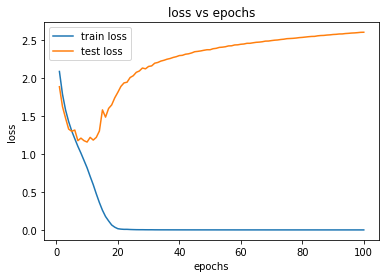

In [ ]:
# plot loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='train loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
plt.legend()
plt.show()

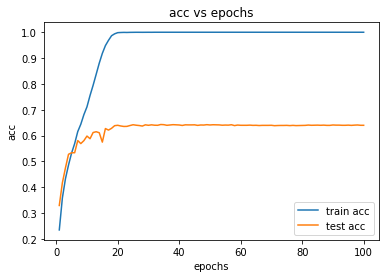

In [ ]:
# plot acc
plt.plot(range(1, NUM_EPOCHS + 1), train_acc, label='train acc')
plt.plot(range(1, NUM_EPOCHS + 1), test_acc, label='test acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title('acc vs epochs')
plt.legend()
plt.show()